The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
x.shape = (4, 3, 3, 2)
x_paded.shape = (4, 7, 7, 2)
x[1, 1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_paded[1, 1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
np.mean(Z) =  0.15585932488906465
cache_conv[0][1][2][3] =  [-0.20075807  0.18656139  0.41005165]
mode = max
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]
----------------------------
mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]
dA_mean = 9.608990675868995
dW_mean = 10.581741275547566
db_mean = 76.37106919563735
mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17

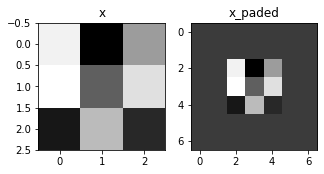

In [5]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

def zero_pad(X, pad):
    """
    功能：
    图像边界用0进行扩充
    
    参数：
    X:图像数据集，维度(样本数，图像高度，图像宽度，通道数)
    pad
    返回值：
    X_paded:扩充后的图像数据集，维度(样本数，图像高度+2*pad，图像宽度+2*pad，通道数)
    """
    X_paded = np.pad(X,
    (
        (0, 0), #样本数，不填充
        (pad, pad), #图像高度,你可以视为上面填充x个，下面填充y个(x,y)
        (pad, pad), #图像宽度,你可以视为左面填充x个，右面填充y个(x,y)
        (0, 0), #通道数，不填充
    ),
        'constant', constant_values = 0
    )
    
    return X_paded
    
    np.random.seed(1)
x = np.random.randn(4,3,3,2)
x_paded = zero_pad(x,2)
#查看信息
print ("x.shape =", x.shape)
print ("x_paded.shape =", x_paded.shape)
print ("x[1, 1] =", x[1, 1])
print ("x_paded[1, 1] =", x_paded[1, 1])

#绘制图
fig , axarr = plt.subplots(1,2)  #一行两列
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_paded')
axarr[1].imshow(x_paded[0,:,:,0])

def conv_single_step(a_slice_prev,W,b):
    """
    功能：
    卷积计算
    参数：
    a_slice_prev:输入数据的一个片段,维度(过滤器大小，过滤器大小，上一通道数)
    W:权重参数,维度(过滤器大小，过滤器大小，上一通道数)
    b:偏置参数,维度(1,1,1)
    返回值：
    Z:输入数据X再卷积窗口(w,b)的结果
    """
    s = np.multiply(a_slice_prev,W) + b
    
    Z = np.sum(s)
    
    return Z

def conv_forward(A_prev, W, b, hparameters):
    """
    功能：
    实现卷积网络前向传播
    参数：
    A_prev:上一层激活函数输出矩阵，维度(m,n_h_prev,n_w_prev,n_c_prev)
    W:权重，维度(f,f,n_c_prev,n_c) f 滤波器的大小 n_c 滤波器数量
    b:偏置，维度(1,1,1,n_c)
    hparameters:超参数字典,stride与pad
    返回值：
    Z:卷积输出，维度(m,n_h,n_w,n_c)
    cache:用于反向传播的缓存
    """
    
    #获取上一层数据的信息
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    #获得权重矩阵的维度
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    #计算卷积后的图片大小
    n_H = int(( n_H_prev - f + 2 * pad )/ stride) + 1
    n_W = int(( n_W_prev - f + 2 * pad )/ stride) + 1
    
    #初始化输出
    Z = np.zeros((m,n_H,n_W,n_C))
    
    #进行pad
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        #第i个样本
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #定位卷积块
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:]
                    #卷积
                    Z[i,h,w,c] = conv_single_step(a_slice_prev,W[:, :, :, c],b[0, 0, 0, c])
    assert(Z.shape == (m, n_H, n_W, n_C))

    #存储用于反向传播的值
    cache = (A_prev,W,b, hparameters)
    
    return (Z, cache)

np.random.seed(1)

A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)

hparameters = {"pad":2, "stride":1}

Z, cache_conv = conv_forward(A_prev,W,b,hparameters)

print("np.mean(Z) = ", np.mean(Z))
print("cache_conv[0][1][2][3] = ", cache_conv[0][1][2][3])

#激活
#A[i, h, w, c] = activation(Z[i, h, w, c])

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    功能：
    池化层的前向传播
    参数：
    A_prev:输入数据，维度(m,n_H_prev,n_W_prev,n_C_prev)
    hparameters:超参数字典,stride或f
    mode:模式，max或average
    返回值：
    A:池化层输出，维度(m,n_H,n_W,n_C)
    cache:用于反向传播的缓存
    """
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    #计算输出维度
    n_H = int((n_H_prev - f) / stride) + 1
    n_W = int((n_W_prev - f) / stride) + 1
    n_C = n_C_prev
    
    #初始化输出矩阵
    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #卷积块的定位
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice_prev = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_slice_prev)
                    else:
                        print("mode error")
                        exit(0)
    
    assert(A.shape == (m, n_H, n_W, n_C))
    
    #缓存用于反向传播的数据
    cache = (A_prev, hparameters)
    
    return (A, cache)

np.random.seed(1)
A_prev = np.random.randn(2,4,4,3)
hparameters = {"f":4 , "stride":1}

A , cache = pool_forward(A_prev,hparameters,mode="max")
print("mode = max")
print("A =", A)
print("----------------------------")
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

def conv_backward(dZ, cache):
    """
    功能:
    实现卷积层的反向传播
    参数：
    dZ:卷积层输出，维度(m, n_H,n_W,n_C)
    cache:反向传播的参数
    返回值：
    dA_prev:卷积层的输入的梯度值
    dW:权重梯度，维度(f, f, n_C_prev,n_C)
    db:偏置梯度，维度(1, 1, 1, n_C)
    """
    #获取cache
    (A_prev, W, b, hparameters) = cache
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (m, n_H, n_W, n_C) = dZ.shape
    
    (f, f, n_C_prev, n_C) = W.shape
    
    pad = hparameters["pad"]
    stride = hparameters["stride"]
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_W):
            for w in range(n_W):
                for c in  range(n_C):
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
                
            
        dA_prev[i,:,:,:] = da_prev_pad[pad:-pad, pad:-pad, :]
        
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return (dA_prev, dW, db)

np.random.seed(1)
#初始化参数
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2, "stride": 1}

#前向传播
Z , cache_conv = conv_forward(A_prev,W,b,hparameters)
#反向传播
dA , dW , db = conv_backward(Z,cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

def create_mask_from_window(x):
    """
    功能：
    从输入矩阵中创建掩码，保存最大值的矩阵位置
    参数:
    x:输入矩阵，维度(f, f)
    返回值:
    mask:包含x最大值位置的矩阵
    """
    
    mask = (x == np.max(x)) 
    
    return mask


def distribute_value(dz, shape):
    """
    功能:
    将给定值，按矩阵大小均匀分配到每个位置
    参数:
    dz:输入的值
    shape:元组，(n_H, n_W)
    返回值:
    a:输出矩阵
    """
    
    (n_H, n_W) = shape
    
    average = dz / (n_H * n_W)
    
    a = np.ones(shape) * average
    
    return a

def pool_backward(dA, cache, mode="max"):
    """
    功能：
    实现池化层反向传播
    参数：
    dA:池化层输出的梯度
    cache:缓存
    mode:max or average
    返回值：
    dA_prev:池化层输入梯度
    """
    (A_prev, hparameters) = cache
    
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (m, n_H, n_W, n_C) = dA.shape
    
    dA_prev = np.zeros_like(A_prev)
    
    for i in range(m):
        a_prev = A_prev[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #定位切片位置
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c] += np.multiply(mask,dA[i,h,w,c])
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)

                        dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c] += distribute_value(da, shape)
                        
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

